# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000

In [6]:
df['calls'] = df['calls'].astype('Int64')
df['messages'] = df['messages'].astype('Int64')

In [7]:
df.head()

calls  minutes  messages   mb_used  is_ultra
0     40   311.90        83  19915.42         0
1     85   516.75        56  22696.96         0
2     77   467.66        86  21060.45         0
3    106   745.53        81   8437.39         1
4     66   418.74         1  14502.75         0

In [8]:
df.duplicated().sum()

0

### Вывод
- Пропущенных значений нет</br>
- Типы столбцов в порядке</br>
- Дубликатов нет</br>

## Разбейте данные на выборки

In [9]:
features = df.drop(['is_ultra'], axis = 1)
target = df['is_ultra']

Т.к. у нас один датасет, то делить его будем на 3 части: обучаемая(60%), валидационная (20%) и тестовая (20%)

In [10]:
#Отделение тестовой части
x, features_test, y, target_test = train_test_split(features, target, test_size=0.2, train_size=0.8)

In [11]:
#Отделения валидационной и обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(x, y, test_size = 0.25, train_size =0.75)

In [12]:
#Проверка разделения
def check(data):
    res = len(data)/len(df)
    print('Процент выборки:', res, ', Количество строк и столбцов:', data.shape)
    
data_list = [features_train, features_valid, target_train, target_valid, features_test, target_test]
for i in data_list:
    check(i)

Процент выборки: 0.5998755444928439 , Количество строк и столбцов: (1928, 4)
Процент выборки: 0.2000622277535781 , Количество строк и столбцов: (643, 4)
Процент выборки: 0.5998755444928439 , Количество строк и столбцов: (1928,)
Процент выборки: 0.2000622277535781 , Количество строк и столбцов: (643,)
Процент выборки: 0.2000622277535781 , Количество строк и столбцов: (643, 4)
Процент выборки: 0.2000622277535781 , Количество строк и столбцов: (643,)


## Исследуйте модели

### Решающее дерево

In [13]:
best_model_dt = None
best_model_dt_depth = 0
best_model_dt_leaf = 0
best_model_dt_split = 0
best_result_dt = 0
for depth in range(1, 13):
    for i in range(1, 50):
        for j in range(2, 30):
            model_dt = DecisionTreeClassifier(random_state=12345, max_depth = depth, min_samples_leaf = i, min_samples_split = j) 
            model_dt.fit(features_train, target_train) 
            predictions_dt = model_dt.predict(features_valid) 
            result_dt = accuracy_score(target_valid, predictions_dt)
            if result_dt > best_result_dt:
                best_model_dt = model_dt
                best_model_dt_depth = depth
                best_model_dt_leaf = i
                best_model_dt_split = j
                best_result_dt = result_dt
print("Лучший результат:", best_result_dt, end='') 
print(" Гиперпараметры:", "max_depth:", best_model_dt_depth, ", min_samples_leaf:", best_model_dt_leaf, ", min_samples_split:", best_model_dt_split)

Лучший результат: 0.838258164852255 Гиперпараметры: max_depth: 7 , min_samples_leaf: 3 , min_samples_split: 15


### Случайный лес

In [14]:
best_model_rf = None
best_model_rf_est = 0
best_model_rf_depth = 0
best_result_rf = 0
rf_score_list = []
rf_est = []
rf_depth = []
for est in range(1, 60):
    for dpth in range(1, 30):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = dpth) 
        model_rf.fit(features_train, target_train) 
        predictions_rf = model_rf.predict(features_valid) 
        result_rf = model_rf.score(features_valid, target_valid)
        rf_est.append(est)
        rf_score_list.append(result_rf)
        rf_depth.append(dpth)
        if result_rf > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_model_rf_est = est
            best_model_rf_depth = dpth
print("Лучший результат:", best_result_rf, end='') 
print(" Гиперпараметры:", "n_estimators:", best_model_rf_est, ", max_depth:", best_model_rf_depth)

Лучший результат: 0.8398133748055988 Гиперпараметры: n_estimators: 48 , max_depth: 9


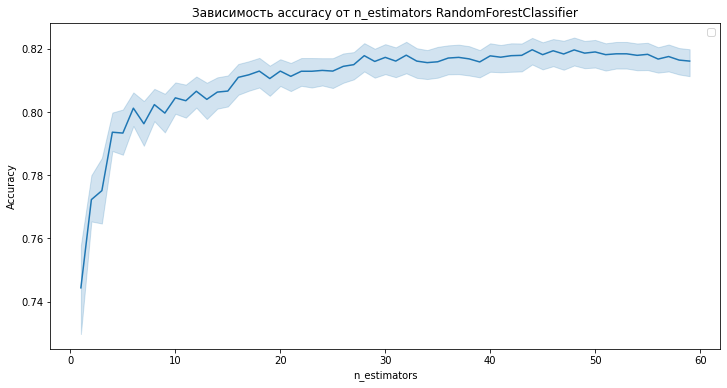

In [15]:
rf_plt = pd.Series(rf_score_list, rf_est)
plt.figure(figsize=(12,6))
sns.lineplot(data=rf_plt)
plt.title("Зависимость accuracy от n_estimators RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend('')
plt.show()

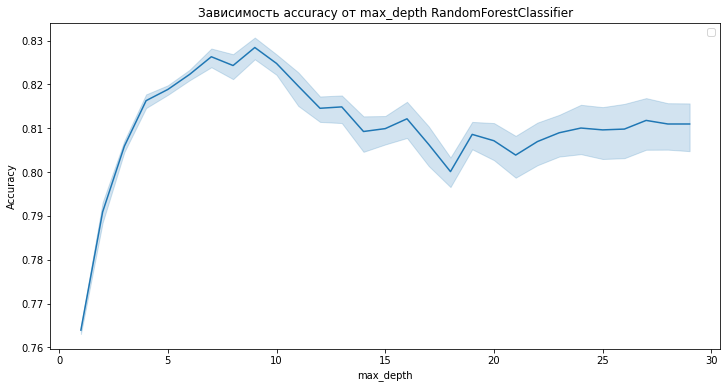

In [16]:
rf_plt = pd.Series(rf_score_list, rf_depth)
plt.figure(figsize=(12,6))
sns.lineplot(data=rf_plt)
plt.title("Зависимость accuracy от max_depth RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend('')
plt.show()

### Логистическая регрессия

In [17]:
best_model_lg = None
best_model_lg_it = 0
best_result_lg = 0
lg_score_list = []
lg_it = []
for it in range(100, 10000, 100):
    model_lg = LogisticRegression(random_state=12345, solver='lbfgs', max_iter = it) 
    model_lg.fit(features_train, target_train) 
    predictions_lg = model_lg.predict(features_valid) 
    result_lg = model_lg.score(features_valid, target_valid)
    lg_it.append(it)
    lg_score_list.append(result_lg)
    if result_lg > best_result_lg:
        best_model_lg = model_lg
        best_result_lg = result_lg
        best_model_lg_it = it
print("Лучший результат:", best_result_lg, end='') 
print(" Гиперпараметры:", "n_estimators:", best_model_lg_it)

Лучший результат: 0.7791601866251944 Гиперпараметры: n_estimators: 100


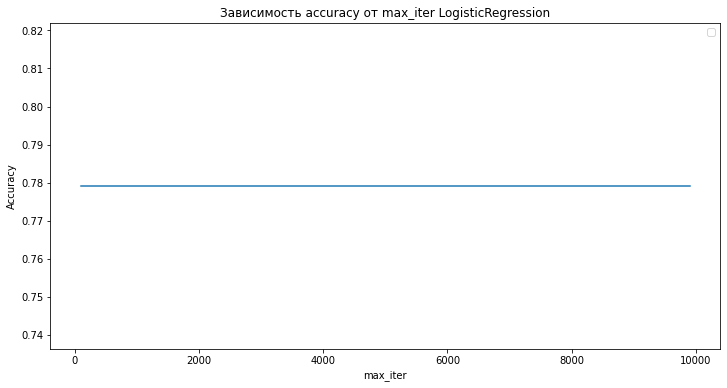

In [18]:
lg_plt = pd.Series(lg_score_list, lg_it)
plt.figure(figsize=(12,6))
sns.lineplot(data=lg_plt)
plt.title("Зависимость accuracy от max_iter LogisticRegression")
plt.xlabel("max_iter")
plt.ylabel("Accuracy")
plt.legend('')
plt.show()

### Вывод

- DecisionTree: Лучший результат: 0.838258164852255 Гиперпараметры: max_depth: 7 , min_samples_leaf: 3 , min_samples_split: 15
- RandomForestClassifier: Лучший результат: 0.8398133748055988 Гиперпараметры: n_estimators: 48 , max_depth: 9
- LogisticRegression: Лучший результат: 0.7791601866251944 Гиперпараметры: n_estimators: 100

Основываясь на показателе точности, можно прийти к выводу, что наиболее качественные результаты прогнозирует Random Forest

## Проверьте модель на тестовой выборке

In [19]:
#Проверка модели DecisionTreeClassifier на тестовой выборке 
predictions_dt_test = best_model_dt.predict(features_test) 
result_dt_test = accuracy_score(target_test, predictions_dt_test)
print("Точность решающего дерева на тестовой выборке:", result_dt_test)

Точность решающего дерева на тестовой выборке: 0.8055987558320373


In [20]:
#Проверка модели RandomForestClassifier на тестовой выборке
predictions_rf_test = best_model_rf.predict(features_test)
result_rf_test = accuracy_score(target_test, predictions_rf_test)
print("Точность случайного леса на тестовой выборке:", result_rf_test)

Точность случайного леса на тестовой выборке: 0.807153965785381


In [21]:
#Проверка модели LogisticRegression на тестовой выборке
predictions_lg_test = best_model_lg.predict(features_test) 
result_lg_test = accuracy_score(target_test, predictions_lg_test)
print("Точность Логистическая  регрессии на тестовой выборке:", result_lg_test)

Точность Логистическая  регрессии на тестовой выборке: 0.7340590979782271


### Вывод

Наиболее точные предсказания делает Random Forest, это видно по точности предсказания на валидационной и на тестовой выборке

## (бонус) Проверьте модели на адекватность

In [22]:
report = classification_report(target_test, best_model_dt.predict(features_test), target_names= ['class 0', 'class 1'])
print("Решающее дерево:")
print(report)

Решающее дерево:
              precision    recall  f1-score   support

     class 0       0.80      0.96      0.87       441
     class 1       0.84      0.47      0.60       202

    accuracy                           0.81       643
   macro avg       0.82      0.71      0.74       643
weighted avg       0.81      0.81      0.79       643



In [23]:
report = classification_report(target_test, best_model_rf.predict(features_test), target_names= ['class 0', 'class 1'])
print("Случайный лес:")
print(report)

Случайный лес:
              precision    recall  f1-score   support

     class 0       0.80      0.95      0.87       441
     class 1       0.82      0.50      0.62       202

    accuracy                           0.81       643
   macro avg       0.81      0.72      0.74       643
weighted avg       0.81      0.81      0.79       643



In [24]:
report = classification_report(target_test, best_model_lg.predict(features_test), target_names= ['class 0', 'class 1'])
print("Логистическая регрессия:")
print(report)

Логистическая регрессия:
              precision    recall  f1-score   support

     class 0       0.73      0.96      0.83       441
     class 1       0.74      0.24      0.36       202

    accuracy                           0.73       643
   macro avg       0.74      0.60      0.60       643
weighted avg       0.74      0.73      0.68       643



In [25]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(features_train, target_train)
DummyClassifier(random_state=0, strategy='most_frequent')
score = clf.score(features_test, target_test)
print('Точность Dummy:', score)

Точность Dummy: 0.6858475894245724


### Вывод

Обученные модели с подобранными гиперпараметрами дают точность выше, чем DummyClassifier